## Empirical Examples from Kim, 1987, using p values

### 1. Import libraries

In [1]:
%reset
import numpy as np
import matplotlib.pyplot as plt
import operator as op
from functools import reduce
import time
from scipy import stats
import random as rnd
import spm1d

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


### 2. Cutting functions: Class definition

In [2]:
# the class allow to define both cutting functions and permutations, in order to execute a bisection method or randomly
class CPfunctions():
    def __init__(self, 
                 Ndata, cut = None, perm = None):
        self.N = Ndata   # size of the data
    def permutation(self, random = False):
        """
        Define the permutation index for a bisection method, or in a random fashion if random is True
        """
        N = self.N
        K = np.arange(1,N+1)
        new_K = []
        if random:
            np.random.shuffle(K)
            new_K = K
        else:
            k_first = list(K)
            k_first.sort()
            K_List = [k_first]
            K_marker = [0]  # index that says if the corresponding K_List has been partitioned or not

            for i in range(N):
                # choose list to divide
                for j in range(len(K_List)):
                    if K_marker[j] == 0 and len(K_List[j]) >= 1:
                        length_K = len(K_List[j])
                        # choose position of new_K in the list
                        K_position = (length_K+1)//2 -1   # the middle (even) or the first integer greater than the middle (odd)
                        new_K.append(K_List[j][K_position])
                        # split the existing array            
                        K_List.append(K_List[j][:K_position])
                        K_List.append(K_List[j][K_position+1:])
                        K_marker[j] = 1
                        K_marker.append(0)
                        K_marker.append(0)
                        # now add elements to H_new
                        break
                        
        self.perm = np.array(new_K)
        
    def cutting(self, random = False):
        """
        Define the cutting functions for a bisection method, or in a random fashion if random is True
        """
        N = self.N
        H = np.random.randint(0, 2, N)
        K = self.perm
        new_H = H
        if not random:            
            H_counter = []   # counter to asign values of H
            h = 0
            while sum(H_counter) <= len(new_H):
                H_counter.append(2**h)
                h = h+1

            H_value = [0]*len(H_counter)    # values of H to asign
            for i in range(len(H_value)):
                if i%2 == 1:
                    H_value[i] = 1

            # for each element in K, asign the corresponding element in H

            for i in range(N):
                for m in range(len(H_value)):
                    if i+1 <= sum(H_counter[:m+1]):
                        new_H[K[i]-1] = H_value[m]
                        break
                        
        self.cut = np.array(new_H)


### 3. Blocks: Class definition

### Let's define a class to work with the blocks

In [3]:
class block():
    def __init__(self, 
                 vertices = None, 
                 elements = None, 
                 stats = None, 
                 parent = None, 
                 leftChild = None, 
                 rightChild = None, 
                 prefChild = None):
        self.vertices = vertices   # array with 2 bidimensional elements, corresponding to the vertices of the block
                                   # vertices must be ordered starting from the left bottom vertix and finishing with the
                                   # right top vertix
                                   # the array must have two rows and two columns (bidimensional case)
        self.elements = elements   # array with the points that belong to the block. Each row contains an element and each
                                   # column is a dimension (in this case, bidimensional)
        self.stats = np.sort(stats) # array with index of blocks
        self.parent = parent       # parent of the block
        self.leftChild = leftChild
        self.rightChild = rightChild
        self.prefChild = prefChild
    
    def plot(self, color = 'C0', lw = 1, size = 12, print_num = True):
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[0,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[1,0], self.vertices[:,1], color = color, lw = lw)
        plt.plot(self.vertices[:,0], np.ones(2)*self.vertices[1,1], color = color, lw = lw)
        plt.plot(np.ones(2)*self.vertices[0,0], self.vertices[:,1], color = color, lw = lw)
        xplot = (self.vertices[0,0]+self.vertices[1,0])/2
        yplot = (self.vertices[0,1]+self.vertices[1,1])/2
        if self.stats.size == 1 and print_num:
            plt.text(xplot, yplot, str(self.stats[0]), fontsize = size)

        
    def split(self, axis, korder):
        """
        This method split a Block and creates two child blocks, making the partition on the korder th statistic
        axis: indicates wheter it is along the X axis (vertical, 0) or the Y axis (horizontal, 1)
        korder: is the order statistic to make the partition
        """
        # select the dimension to sort
        Xele = self.elements[:,axis]
        # select the kth order statistic
        Xorder = np.sort(Xele)
        minStat = min(self.stats)
        korder = korder - minStat
        xstat = Xorder[korder]
        # divide the stats
        statsL = self.stats[:korder+1]
        statsR = self.stats[korder+1:]
        # create the elements and vertices of each block
        Relements = np.empty((0, 2))
        Lelements = np.empty((0, 2))
        
        # add elements to vertices and elements for each case
        if axis == 0:
            Lvertices = np.array([self.vertices[0,:], [xstat, self.vertices[1,1]]])
            Rvertices = np.array([[xstat, self.vertices[0,1]], self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]  # chosen kth order 
        elif axis == 1:
            Lvertices = np.array([self.vertices[0,:], [self.vertices[1,0], xstat]])
            Rvertices = np.array([[self.vertices[0,0], xstat],self.vertices[1,:]])
            # now we move on the elements of the parent block and select wich ones go to the left and right child
            for l in range(self.elements.shape[0]):
                if Xele[l] < xstat:
                    Lelements = np.append(Lelements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                elif Xele[l] > xstat:
                    Relements = np.append(Relements, [self.elements[l, :]], axis = 0)   # add the new element as a row
                else:
                    Pchild = [self.elements[l,:]]   # chosen kth order 
                
        # create the childs of the block
        Rchild = block(vertices = Rvertices, elements = Relements, stats = statsR, parent = self)  
        # right side or up side (the greaters elements)
        Lchild = block(vertices = Lvertices, elements = Lelements, stats = statsL, parent = self)   
        # left side or down side (the smaller elements)
        
        # asociate the childs to the parten
        self.rightChild = Rchild
        self.leftChild = Lchild
        self.prefChild = Pchild
        # return the place where the partition was made
        return xstat
    
    def belong(self, x):
        nx = x.shape[0]
        out = True
        for i in range(nx):
            out = out and self.vertices[0,i] < x[i] <= self.vertices[1,i]
        return out

        

In [4]:
# other functions to calculate distributions and order blocks

def ncr(n, r):
    r = min(r, n-r)
    numer = reduce(op.mul, range(n, n-r, -1), 1)
    denom = reduce(op.mul, range(1, r+1), 1)
    return numer / denom

def prob_M_null(s, N, M):
    """
    Calculate probabilitie that exactly s of the ma's are 0, under H0
    N is the size of data that defined the blocks (therefore, s in {0,...,N})
    M is the size of new data that is being compared
    """    
    if N >= M-1 and s < N-M+1:
        return 0
    else:
        num = ncr(N+1, s)*ncr(M-1, N-s)
        den = ncr(M+N, N)
        return num/den
    
    return num/den

def order_blocks(Blocks):
    """
    order the final blocks, so in the list of blocks they will be on the order corresponding to their statistics
    """
    Blocks_Order = []
    N_Blocks = len(Blocks)
    Assigned_Blocks = 0
    i = 0
    while Assigned_Blocks < N_Blocks:
        if Blocks[int(i%N_Blocks)].stats[0] == Assigned_Blocks+1:
            Blocks_Order.extend([Blocks[i%N_Blocks]])
            Assigned_Blocks = Assigned_Blocks + 1
        i = i + 1  # search in another block
    return Blocks_Order

def counting_blocks(Blocks, data):
    """
    counts the number of elementos from data belonging to each block of the list Blocks
    """
    data_copy = np.copy(data)   # copy Y to eliminate the elements already assigned to a block
    Ma = np.zeros(len(Blocks))  # 

    # calculate the values of m_{alpha}
    for k in range(len(Blocks)):
        i = 0
        while i < data_copy.shape[0]:   # count the elements that belong to the k-th block
            if Blocks[k].belong(data_copy[i,:]):
                Ma[k] = Ma[k] + 1
                data_copy = np.delete(data_copy, i, axis = 0)  # eliminate to make a shorter search
                i = i - 1
            i = i + 1
    return Ma

def rank_by_blocks(blocks, countings):
    """
    vectors of ranking for each sample according to the constructed blocks
    """
    rank_flag = True
    rank_correction = 1
    ranks_1 = []
    ranks_2 = []
    for i in range(len(blocks)):
        if countings[i] == 0 & rank_flag:
            ranks_1.append(rank_correction)
            rank_correction += 1
            rank_flag = False
        elif countings[i] != 0 & rank_flag:
            ranks_2.extend(np.arange(rank_correction,rank_correction + countings[i]))
            rank_correction += countings[i]
            ranks_1.append(rank_correction)
            rank_correction += 1
            rank_flag = False
        elif countings[i] == 0:
            ranks_1.append(rank_correction)
            rank_correction += 1
        elif countings[i] != 0:
            ranks_2.extend(np.arange(rank_correction,rank_correction + countings[i]))
            rank_correction += countings[i]
            ranks_1.append(rank_correction)
            rank_correction += 1
    ranks_1.remove(ranks_1[-1])
    return ranks_1, ranks_2


### 4. Blocks from data X
### We proceed to use the block class to apply the partition in an iterative loop

[0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
[16  8 24  4 12 20 28  2  6 10 14 18 22 26 30  1  3  5  7  9 11 13 15 17
 19 21 23 25 27 29 31 32]
[1 0 0 1 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0]
(32, 0)


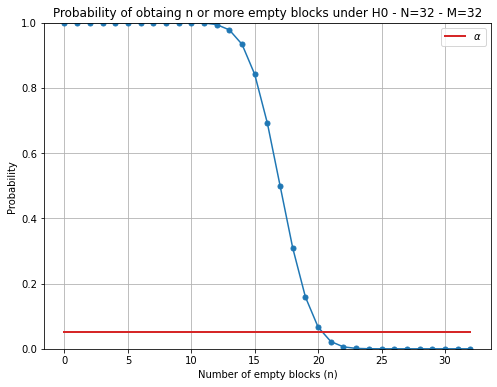

In [9]:
# data from Kim
# data from kim

models = {"dist":['Location', 'Scale', 'Mixture', 'Correlation'], "code":[0,1,2,3]}

# choose the code
code = 0

dist_type = models["dist"][code]

# define moments
meanX = 1.0*np.array([0,0])
meanX_1 = 0.85*np.array([1,1])
meanX_2 = -0.85*np.array([1,1])
covX = 1.0*np.array([[1,0],[0,1]])
meanY = 1.0*np.array([0,0])
covY = 1.0*np.array([[1,0],[0,1]])

# modify moments if necessary
if code == 0:
    meanX = 0.7*np.array([1,1])
elif code == 1:
    covY *= 3
elif code == 2:
    covX *= 0.281
else:
    covX = np.array([[1,-0.5],[-0.5,1]])
    covY = np.array([[1,0.5],[0.5,1]])

# number of samples per set. N for X, M for Y
N = 32
M = 32

fac = 1
Xmin = fac*min(meanX[0]-4*covX[0,0], meanX_1[0]-4*covX[0,0], meanX_2[0]-4*covX[0,0], meanY[0]-4*covY[0,0])
Xmax = fac*max(meanX[0]+4*covX[0,0], meanX_1[0]+4*covX[0,0], meanX_2[0]-4*covX[0,0], meanY[0]+4*covY[0,0])
Ymin = fac*min(meanX[1]-4*covX[1,1], meanX_1[1]-4*covX[1,1], meanX_2[1]-4*covX[1,1], meanY[1]-4*covY[1,1])
Ymax = fac*max(meanX[1]+4*covX[1,1], meanX_1[1]+4*covX[1,1], meanX_2[1]+4*covX[1,1], meanY[1]+4*covY[1,1])
    
# define cutting functions and permutation order, blocks from data X
Lists_X = CPfunctions(N)
Lists_X.permutation()
Lists_X.cutting()
K_X = Lists_X.perm
H_X = Lists_X.cut
print(H_X[K_X-1])
# uncomment next lines to start cutting through the vertical axis
#H_X_bool = H_X == 0
#H_X = H_X_bool*1
print(K_X)
print(H_X[K_X-1])

# let's calculate the S distribution, under H0 (does not depend on the samples) and considering N+1 blocks (from X)
s_prob_X = np.zeros(N+1)  # there are N + 1 blocks

for s in range(N+1):
    s_prob_X[s] = prob_M_null(s, N, M)

# let's calculate the complement cumulative distribution, under H0 and for N+1 blocks
# (we calculate the probability to have at least s m_a's that are 0)
S_prob_X = np.zeros(N+1)
for s in range(N+1):
    S_prob_X[s] = sum(s_prob_X[s:])
    
# confidence level
alpha = 0.05
    
fig = plt.figure(figsize=(8,6))
plt.plot(range(0, N+1), S_prob_X, 'o-', color = 'C0', ms = 5)
plt.plot([0,N], [alpha, alpha], '-', color = 'C3', lw = 2, label = r'$\alpha$')
plt.xlabel('Number of empty blocks (n)')
plt.ylabel('Probability')
plt.title('Probability of obtaing n or more empty blocks under H0 - N='+str(N)+' - M='+str(M))
plt.ylim(0,1)
plt.grid()
plt.legend()

# find the element with significance level closer to alpha (for X, just an example)

def EB_test_stats(S_prob, alpha):
    """
    return the stats to evaluate the empty block test for a given confidence level alpha
    """
    
    CV = (np.abs(S_prob-alpha)).argmin()
    # if it is the last, do not do anything else
    if S_prob[CV] < alpha:
        CV -= 1
    # define probability of reject H0 when #empty blocks = index
    if CV == len(S_prob)-1:
        Pr = 0
    else:
        Pr = (alpha- S_prob[CV + 1])/(S_prob[CV]-S_prob[CV+1])

    return CV, Pr#, S_prob[CV+1]

print(EB_test_stats(S_prob_X,0))


### 5. Blocks from data Y

(20, 0.6279749330087897)
[1]


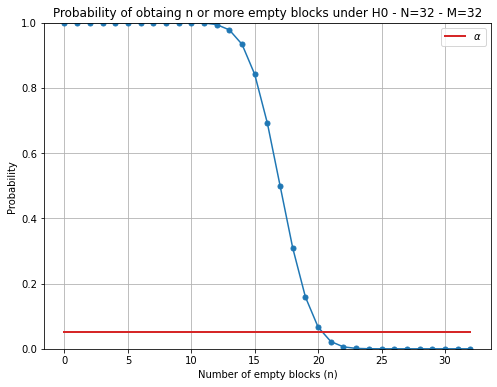

In [10]:
# define cutting functions and permutation order, blocks from data Y
Lists_Y = CPfunctions(M)
Lists_Y.permutation()
Lists_Y.cutting()
K_Y = Lists_Y.perm
H_Y = Lists_Y.cut
# to start cuttin by the vertical axis
#H_Y_bool = H_Y == 0
#H_Y = H_Y_bool*1

# let's calculate the S distribution, under H0 (does not depend on the samples) and considering M+1 blocks (from Y)
s_prob_Y = np.zeros(M+1)  # there are M + 1 blocks

for s in range(M+1):
    s_prob_Y[s] = prob_M_null(s, M, N)   # we have M+1 blocks and N samples

# let's calculate the complement cumulative distribution, under H0 and for N+1 blocks
# (we calculate the probability to have at least s m_a's that are 0)
S_prob_Y = np.zeros(M+1)
for s in range(M+1):
    S_prob_Y[s] = sum(s_prob_Y[s:])

    
fig = plt.figure(figsize=(8,6))
plt.plot(range(0, M+1), S_prob_Y, 'o-', color = 'C0', ms = 5)
plt.plot([0,M], [alpha, alpha], '-', color = 'C3', lw = 2, label = r'$\alpha$')
plt.xlabel('Number of empty blocks (n)')
plt.ylabel('Probability')
plt.title('Probability of obtaing n or more empty blocks under H0 - N='+str(N)+' - M='+str(M))
plt.ylim(0,1)
plt.grid()
plt.legend()

# find the element with significance level lower and closer to alpha (for X, just an example)


print(EB_test_stats(S_prob_Y,alpha))


Pr_comb = np.random.binomial(size=1, n=1, p= 0.5)  # 0 to choose X, 1 to choose Y
print(Pr_comb)


### We excecute Nrep repetitions of every test, generating diferent samples and combining pvalues

In [11]:

Nrep = 1000   # number of repetitions

counterX = 0   # counts the number of rejections of H0 using X blocks
counterY = 0   # counts the number of rejections of H0 using Y blocks
counterX_p = 0
counterY_p = 0
counterGood = 0
counterBonf = 0
counterComb = 0 # test that combines X block and Y block randomly

alpha = 0.05

CV_X, Pr_X = EB_test_stats(S_prob_X,alpha)
CV_Y, Pr_Y = EB_test_stats(S_prob_Y,alpha)

start = time.time()

for repetition in range(Nrep):
    #generate X data
    X = np.random.multivariate_normal(meanX, covX, N)#*0.5 + 0.05*np.random.multivariate_normal(-meanX, covX, N)
    # mixture case
    if code == 2:
        X = np.concatenate((np.random.multivariate_normal(meanX_1, covX, int(N/2)),
                        np.random.multivariate_normal(meanX_2, covX, N-int(N/2))),
                        axis = 0)
    # generate Y data
    Y = np.random.multivariate_normal(meanY, covY, M)  # let's use the same distribution
    
    # create list with blocks for X
    First_Block_X = block(vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]), elements = X,
                          stats = range(1,N+2))

    Blocks_List_X = [First_Block_X]

    step = N
    
    for i in range(step):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List_X)):
            if K_X[i] in Blocks_List_X[j].stats and Blocks_List_X[j].leftChild == None:
                Blocks_List_X[j].split(axis = H_X[K_X[i]-1], korder = K_X[i])
                Blocks_List_X.extend([Blocks_List_X[j].leftChild, Blocks_List_X[j].rightChild])
                break

    Blocks_Final_X = []

    for j in range(len(Blocks_List_X)):
        if Blocks_List_X[j].leftChild == None:
            Blocks_Final_X.extend([Blocks_List_X[j]])


    # order the blocks and count their elements
    Blocks_Order_X = order_blocks(Blocks_Final_X)
    Ma_X = counting_blocks(Blocks_Order_X, Y)


    # finally count the null elements for the empty block test
    M_nulls_X = np.count_nonzero(Ma_X==0)
    # print(M_nulls)
    # M_nulls calculate the number of empty blocks. Let's calculate the probability of have M_nulls or more empty blocks
    # That is storaged in S_prob
    
    Pr_comb = np.random.binomial(n=1, p= 0.5)  # 0 to choose X, 1 to choose Y

    # we reject if the number of empty blocks is greater than the critical value
    
    p_value_X = S_prob_X[M_nulls_X]
    
    if M_nulls_X > CV_X:
        counterX += 1
        if Pr_comb == 0:
            counterComb += 1
    elif M_nulls_X == CV_X:
        # reject randomly with prob X_cv
        if Pr_X >= rnd.uniform(0.0, 1.0):  # rho = 1
            counterX += 1 
            #p_value_X = S_prob_X[M_nulls_X+1]
            if Pr_comb == 0:
                counterComb += 1
        
    # we fail to reject the null hypothesis if the p-value is greater or equal than alpha
    # we reject if the p-value is lower than alpha
    
    if p_value_X <= alpha:  # reject the test
        counterX_p = counterX_p + 1
        
    # now create the blocks from Y
    First_Block_Y = block(vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]), elements = Y, stats = range(1,M+2))

    Blocks_List_Y = [First_Block_Y]

    step = M

    for i in range(step):
        # search the last block that has the K[i] stat
        for j in range(len(Blocks_List_Y)):
            if K_Y[i] in Blocks_List_Y[j].stats and Blocks_List_Y[j].leftChild == None:
                Blocks_List_Y[j].split(axis = H_Y[K_Y[i]-1], korder = K_Y[i])
                Blocks_List_Y.extend([Blocks_List_Y[j].leftChild, Blocks_List_Y[j].rightChild])
                break

    Blocks_Final_Y = []

    for j in range(len(Blocks_List_Y)):
        if Blocks_List_Y[j].leftChild == None:
            Blocks_Final_Y.extend([Blocks_List_Y[j]])
            
    # test if both data samples come from the same distribution

    # order the blocks and count their elements
    Blocks_Order_Y = order_blocks(Blocks_Final_Y)
    Ma_Y = counting_blocks(Blocks_Order_Y, X)
    
    # finally count the null elements
    M_nulls_Y = np.count_nonzero(Ma_Y==0)
    # print(M_nulls)
    # M_nulls calculate the number of empty blocks. Let's calculate the probability of have M_nulls or more empty blocks
    # That is storaged in S_prob
    
    p_value_Y = S_prob_Y[M_nulls_Y]
    
    if M_nulls_Y > CV_Y:
        counterY += 1
        if Pr_comb == 1:
            counterComb += 1
    elif M_nulls_Y == CV_Y:
        # reject randomly with prob X_cv
        if Pr_Y >= rnd.uniform(0.0, 1.0):  # rho = 1
            counterY += 1 
            #p_value_Y = S_prob_Y[M_nulls_Y+1]
            if Pr_comb == 1:
                counterComb += 1

    if p_value_Y < alpha:  # reject the test
        counterY_p += 1
        
    # other pvalues, combinating p_value_X and p_value_Y
         
    p_good = 2/(1/p_value_X + 1/p_value_Y)   # Good, 1958
    p_good = min(p_good, 1)
    if p_good < alpha:  # reject the test
        counterGood += 1

    p_bonf = 2*min(p_value_X, p_value_Y)
    p_bonf = min(p_bonf, 1)
    if p_bonf < alpha:  # reject the test
        counterBonf += 1
        
    width = 10
    precision = 4
    #print(f"p_values: {p_value_X:3f}, {p_value_Y:3f}, {p_good:3f}, {p_bonf:3f}")

end = time.time()
print('Empirical powers')

print('Empty X block test Cv', counterX/Nrep)
print('Empty y block test Cv', counterY/Nrep)

print('Empty X block test p', counterX_p/Nrep)
print('Empty y block test p', counterY_p/Nrep)

print('Good formula', counterGood/Nrep)
print('Bonf formula', counterBonf/Nrep)

print('Comb XY block', counterComb/Nrep)

print('Time ', end-start)


Empirical powers
Empty X block test Cv 0.359
Empty y block test Cv 0.386
Empty X block test p 0.261
Empty y block test p 0.277
Good formula 0.408
Bonf formula 0.408
Comb XY block 0.367
Time  15.60353970527649


### Construct the ROC curve for each test

In [58]:
start = time.time()

Nrep = 5000   # number of repetitions
Nalpha = 25
alpha_0 = 0
alpha_end = 0.1
Alpha_vec = np.linspace(alpha_0, alpha_end, Nalpha)
Power_Hotelling = np.zeros(Nalpha)

Power_empty_X = np.zeros(Nalpha)
Power_empty_Y = np.zeros(Nalpha)
Power_empty_X_p = np.zeros(Nalpha)
Power_empty_Y_p = np.zeros(Nalpha)
Power_empty_Good = np.zeros(Nalpha)
Power_empty_Bonf = np.zeros(Nalpha)
Power_empty_Comb = np.zeros(Nalpha)

for alpha_i in range(Nalpha):
    alpha = Alpha_vec[alpha_i]

    counterHotelling = 0

    counterX = 0   # counts the number of rejections of H0 using X blocks
    counterY = 0   # counts the number of rejections of H0 using Y blocks
    counterX_p = 0
    counterY_p = 0
    counterGood = 0
    counterBonf = 0
    counterComb = 0
    
    CV_X, Pr_X = EB_test_stats(S_prob_X,alpha)
    CV_Y, Pr_Y = EB_test_stats(S_prob_Y,alpha)

    for repetition in range(Nrep):
        #generate X data
        X = np.random.multivariate_normal(meanX, covX, N)#*0.5 + 0.05*np.random.multivariate_normal(-meanX, covX, N)
        # mixture case
        if code == 2:
            X = np.concatenate((np.random.multivariate_normal(meanX_1, covX, int(N/2)),
                        np.random.multivariate_normal(meanX_2, covX, N-int(N/2))),
                        axis = 0)
        # generate Y data
        Y = np.random.multivariate_normal(meanY, covY, M)  # let's use the same distribution

        # create list with blocks for X
        First_Block_X = block(vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]), elements = X, stats = range(1,N+2))

        Blocks_List_X = [First_Block_X]

        step = N

        for i in range(step):
            # search the last block that has the K[i] stat
            for j in range(len(Blocks_List_X)):
                if K_X[i] in Blocks_List_X[j].stats and Blocks_List_X[j].leftChild == None:
                    Blocks_List_X[j].split(axis = H_X[K_X[i]-1], korder = K_X[i])
                    Blocks_List_X.extend([Blocks_List_X[j].leftChild, Blocks_List_X[j].rightChild])
                    break

        Blocks_Final_X = []

        for j in range(len(Blocks_List_X)):
            if Blocks_List_X[j].leftChild == None:
                Blocks_Final_X.extend([Blocks_List_X[j]])


        # order the blocks and count their elements
        Blocks_Order_X = order_blocks(Blocks_Final_X)
        Ma_X = counting_blocks(Blocks_Order_X, Y)


        # finally count the null elements for the empty block test
        M_nulls_X = np.count_nonzero(Ma_X==0)
        # print(M_nulls)
        # M_nulls calculate the number of empty blocks. Let's calculate the probability of have M_nulls or more empty blocks
        # That is storaged in S_prob
        
        Pr_comb = np.random.binomial(n=1, p= 0.5)  # 0 to choose X, 1 to choose Y

        # we reject if the number of empty blocks is greater than the critical value

        p_value_X = S_prob_X[M_nulls_X]
        
        if M_nulls_X > CV_X:
            counterX += 1
            if Pr_comb == 0:
                counterComb += 1
        elif M_nulls_X == CV_X:
            # reject randomly with prob X_cv
            if Pr_X >= rnd.uniform(0.0, 1.0):  # rho = 1
                counterX += 1 
                #p_value_X = S_prob_X[M_nulls_X+1]
                if Pr_comb == 0:
                    counterComb += 1
        
        # we fail to reject the null hypothesis if the p-value is greater or equal than alpha
        # we reject if the p-value is lower than alpha

        if p_value_X <= alpha:  # reject the test
            counterX_p += 1

        ############################----------------------------------------
        
        # now create the blocks from Y
        First_Block_Y = block(vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]), elements = Y, stats = range(1,M+2))

        Blocks_List_Y = [First_Block_Y]

        step = M

        for i in range(step):
            # search the last block that has the K[i] stat
            for j in range(len(Blocks_List_Y)):
                if K_Y[i] in Blocks_List_Y[j].stats and Blocks_List_Y[j].leftChild == None:
                    Blocks_List_Y[j].split(axis = H_Y[K_Y[i]-1], korder = K_Y[i])
                    Blocks_List_Y.extend([Blocks_List_Y[j].leftChild, Blocks_List_Y[j].rightChild])
                    break

        Blocks_Final_Y = []

        for j in range(len(Blocks_List_Y)):
            if Blocks_List_Y[j].leftChild == None:
                Blocks_Final_Y.extend([Blocks_List_Y[j]])

        # test if both data samples come from the same distribution

        # order the blocks and count their elements
        Blocks_Order_Y = order_blocks(Blocks_Final_Y)
        Ma_Y = counting_blocks(Blocks_Order_Y, X)

        # finally count the null elements
        M_nulls_Y = np.count_nonzero(Ma_Y==0)
        # print(M_nulls)
        # M_nulls calculate the number of empty blocks. Let's calculate the probability of have M_nulls or more empty blocks
        # That is storaged in S_prob

        p_value_Y = S_prob_Y[M_nulls_Y]
        
        if M_nulls_Y > CV_Y:
            counterY += 1
            if Pr_comb == 1:
                    counterComb += 1
        elif M_nulls_Y == CV_Y:
            # reject randomly with prob X_cv
            if Pr_Y >= rnd.uniform(0.0, 1.0):  # rho = 1
                counterY += 1 
                #p_value_Y = S_prob_Y[M_nulls_Y+1]
                if Pr_comb == 1:
                    counterComb += 1

        if p_value_Y <= alpha:  # reject the null
            counterY_p += 1 

        # other pvalues, combinating p_value_X and p_value_Y
        p_good = 2/(1/p_value_X + 1/p_value_Y)   # Good, 1958
        p_good = min(p_good, 1)
        if p_good <= alpha:  # reject the null
            counterGood += 1

        p_bonf = 2*min(p_value_X, p_value_Y)
        p_bonf = min(p_bonf, 1)
        if p_bonf <= alpha:  # reject the null
            counterBonf += 1
            
        T2 = spm1d.stats.hotellings2(X,Y)
        T2i = T2.inference(alpha)
        if T2i.h0reject:   # reject the null
            counterHotelling += 1

    Power_Hotelling[alpha_i] = counterHotelling/Nrep

    Power_empty_X[alpha_i] = counterX/Nrep
    Power_empty_Y[alpha_i] = counterY/Nrep
    Power_empty_X_p[alpha_i] = counterX_p/Nrep
    Power_empty_Y_p[alpha_i] = counterY_p/Nrep
    Power_empty_Good[alpha_i] = counterGood/Nrep
    Power_empty_Bonf[alpha_i] = counterBonf/Nrep
    Power_empty_Comb[alpha_i] = counterComb/Nrep


end = time.time()

print(end-start, ' s')

1755.5746428966522  s


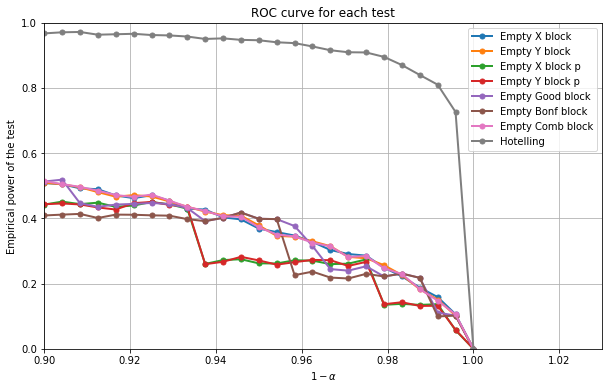

In [59]:
# plot
fig = plt.figure(figsize=(10,6))

plt.plot(1-Alpha_vec, Power_empty_X, '-o',lw = 2, ms = 5,label = 'Empty X block')
plt.plot(1-Alpha_vec, Power_empty_Y, '-o',lw = 2, ms = 5, label = 'Empty Y block')
plt.plot(1-Alpha_vec, Power_empty_X_p, '-o',lw = 2, ms = 5, label = 'Empty X block p')
plt.plot(1-Alpha_vec, Power_empty_Y_p, '-o',lw = 2, ms = 5, label = 'Empty Y block p')
plt.plot(1-Alpha_vec, Power_empty_Good, '-o',lw = 2, ms = 5, label = 'Empty Good block')
plt.plot(1-Alpha_vec, Power_empty_Bonf, '-o',lw = 2, ms = 5, label = 'Empty Bonf block')
plt.plot(1-Alpha_vec, Power_empty_Comb, '-o',lw = 2, ms = 5, label = 'Empty Comb block')

plt.plot(1-Alpha_vec, Power_Hotelling,'-o',lw = 2, ms = 5, label = 'Hotelling')

plt.xlabel(r'$1-\alpha$')
plt.ylabel('Empirical power of the test')
plt.title('ROC curve for each test')
plt.xlim(0.9,1.03)
plt.ylim(0,1)
plt.grid()
plt.legend()

fig.savefig('Combined/ROC-'+dist_type+'-N'+str(N)+'M'+str(M)+'_power_2.pdf', format='pdf', bbox_inches='tight')
fig.savefig('Combined/ROC-'+dist_type+'-N'+str(N)+'M'+str(M)+'_power_2.png', format='png', bbox_inches='tight')

### Now we calculate empirial size of the tests

In [12]:
start = time.time()

Nrep = 5000   # number of repetitions
Nalpha = 25
alpha_0 = 0
alpha_end = 0.1
Alpha_vec = np.linspace(alpha_0, alpha_end, Nalpha)

Size_Hotelling = np.zeros(Nalpha)

Size_empty_X = np.zeros(Nalpha)
Size_empty_Y = np.zeros(Nalpha)
Size_empty_X_p = np.zeros(Nalpha)
Size_empty_Y_p = np.zeros(Nalpha)
Size_empty_Good = np.zeros(Nalpha)
Size_empty_Bonf = np.zeros(Nalpha)
Size_empty_Comb = np.zeros(Nalpha)

for alpha_i in range(Nalpha):
    alpha = Alpha_vec[alpha_i]

    counterHotelling = 0

    counterX = 0   # counts the number of rejections of H0 using X blocks
    counterY = 0   # counts the number of rejections of H0 using Y blocks
    counterX_p = 0
    counterY_p = 0
    counterGood = 0
    counterBonf = 0
    counterComb = 0

    CV_X, Pr_X = EB_test_stats(S_prob_X,alpha)
    CV_Y, Pr_Y = EB_test_stats(S_prob_Y,alpha)
    
    
    for repetition in range(Nrep):
        #generate X data (same as Y)
        X = np.random.multivariate_normal(meanY, covY, N)
        # generate Y data
        Y = np.random.multivariate_normal(meanY, covY, M)  # let's use the same distribution

        # create list with blocks for X
        First_Block_X = block(vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]), elements = X, stats = range(1,N+2))

        Blocks_List_X = [First_Block_X]

        step = N

        for i in range(step):
            # search the last block that has the K[i] stat
            for j in range(len(Blocks_List_X)):
                if K_X[i] in Blocks_List_X[j].stats and Blocks_List_X[j].leftChild == None:
                    Blocks_List_X[j].split(axis = H_X[K_X[i]-1], korder = K_X[i])
                    Blocks_List_X.extend([Blocks_List_X[j].leftChild, Blocks_List_X[j].rightChild])
                    break

        Blocks_Final_X = []

        for j in range(len(Blocks_List_X)):
            if Blocks_List_X[j].leftChild == None:
                Blocks_Final_X.extend([Blocks_List_X[j]])


        # order the blocks and count their elements
        Blocks_Order_X = order_blocks(Blocks_Final_X)
        Ma_X = counting_blocks(Blocks_Order_X, Y)


        # finally count the null elements for the empty block test
        M_nulls_X = np.count_nonzero(Ma_X==0)
        # print(M_nulls)
        # M_nulls calculate the number of empty blocks. Let's calculate the probability of have M_nulls or more empty blocks
        # That is storaged in S_prob
        
        Pr_comb = np.random.binomial(n=1, p= 0.5)  # 0 to choose X, 1 to choose Y

        # we reject if the number of empty blocks is greater than the critical value
        # define the pvalue
        p_value_X = S_prob_X[M_nulls_X]

        if M_nulls_X > CV_X:
            counterX += 1
            if Pr_comb == 0:
                counterComb += 1
        elif M_nulls_X == CV_X:
            # reject randomly with prob X_cv
            if Pr_X >= rnd.uniform(0.0, 1.0):  # rho = 1
                counterX += 1 
                #p_value_X = S_prob_X[M_nulls_X+1]
                if Pr_comb == 0:
                    counterComb += 1
        
        # we fail to reject the null hypothesis if the p-value is greater or equal than alpha
        # we reject if the p-value is lower than alpha
        if p_value_X <= alpha:  # reject the test
            counterX_p +=1

        # now create the blocks from Y
        First_Block_Y = block(vertices = np.array([[Xmin,Ymin],[Xmax,Ymax]]), elements = Y, stats = range(1,M+2))

        Blocks_List_Y = [First_Block_Y]

        step = M

        for i in range(step):
            # search the last block that has the K[i] stat
            for j in range(len(Blocks_List_Y)):
                if K_Y[i] in Blocks_List_Y[j].stats and Blocks_List_Y[j].leftChild == None:
                    Blocks_List_Y[j].split(axis = H_Y[K_Y[i]-1], korder = K_Y[i])
                    Blocks_List_Y.extend([Blocks_List_Y[j].leftChild, Blocks_List_Y[j].rightChild])
                    break

        Blocks_Final_Y = []

        for j in range(len(Blocks_List_Y)):
            if Blocks_List_Y[j].leftChild == None:
                Blocks_Final_Y.extend([Blocks_List_Y[j]])

        # test if both data samples come from the same distribution

        # order the blocks and count their elements
        Blocks_Order_Y = order_blocks(Blocks_Final_Y)
        Ma_Y = counting_blocks(Blocks_Order_Y, X)

        # finally count the null elements
        M_nulls_Y = np.count_nonzero(Ma_Y==0)
        # print(M_nulls)
        # M_nulls calculate the number of empty blocks. Let's calculate the probability of have M_nulls or more empty blocks
        # That is storaged in S_prob
        
        p_value_Y = S_prob_Y[M_nulls_Y]

        if M_nulls_Y > CV_Y:
            counterY += 1
            if Pr_comb == 1:
                counterComb += 1
        elif M_nulls_Y == CV_Y:
            # reject randomly with prob X_cv
            if Pr_Y >= rnd.uniform(0.0, 1.0):  # rho = 1
                counterY += 1 
                #p_value_Y = S_prob_Y[M_nulls_Y+1]
                if Pr_comb == 1:
                    counterComb += 1

        if p_value_Y <= alpha:  # reject the test
            counterY_p += 1 

        # other pvalues, combinating p_value_X and p_value_Y
        p_good = 2/(1/p_value_X + 1/p_value_Y)   # Good, 1958
        p_good = min(p_good, 1)
        if p_good < alpha:  # reject the test
            counterGood = counterGood + 1

        p_bonf = 2*min(p_value_X, p_value_Y)
        p_bonf = min(p_bonf, 1)
        if p_bonf < alpha:  # reject the test
            counterBonf = counterBonf + 1
            
        T2 = spm1d.stats.hotellings2(X,Y)
        T2i = T2.inference(alpha)
        if T2i.h0reject:   # reject the test
            counterHotelling += 1

    Size_Hotelling[alpha_i] = counterHotelling/Nrep

    Size_empty_X[alpha_i] = counterX/Nrep
    Size_empty_Y[alpha_i] = counterY/Nrep
    Size_empty_X_p[alpha_i] = counterX_p/Nrep
    Size_empty_Y_p[alpha_i] = counterY_p/Nrep
    Size_empty_Good[alpha_i] = counterGood/Nrep
    Size_empty_Bonf[alpha_i] = counterBonf/Nrep
    Size_empty_Comb[alpha_i] = counterComb/Nrep


end = time.time()

print(end-start, ' s')

1766.7781989574432  s


[1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00
 1.00000000e+00 1.00000000e+00 9.99999996e-01 9.99999893e-01
 9.99998177e-01 9.99978255e-01 9.99812239e-01 9.98794006e-01
 9.94110137e-01 9.77716593e-01 9.33580129e-01 8.41427073e-01
 6.91349239e-01 5.00000000e-01 3.08650761e-01 1.58572927e-01
 6.64198709e-02 2.22834071e-02 5.88986348e-03 1.20599386e-03
 1.87761330e-04 2.17451569e-05 1.82321620e-06 1.06864385e-07
 4.17666990e-09 1.01760550e-10 1.39332498e-12 8.94946194e-15
 1.80069657e-17]


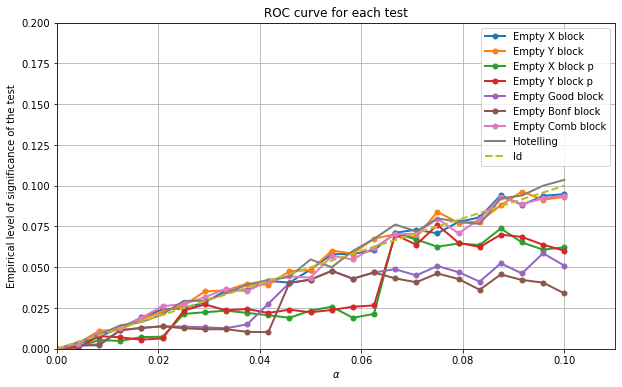

In [13]:
# plot
print(S_prob_X)
fig = plt.figure(figsize=(10,6))

plt.plot(Alpha_vec, Size_empty_X, '-o',lw = 2, ms = 5, label = 'Empty X block')
plt.plot(Alpha_vec, Size_empty_Y, '-o',lw = 2, ms = 5, label = 'Empty Y block')
plt.plot(Alpha_vec, Size_empty_X_p, '-o',lw = 2, ms = 5, label = 'Empty X block p')
plt.plot(Alpha_vec, Size_empty_Y_p, '-o',lw = 2, ms = 5, label = 'Empty Y block p')
plt.plot(Alpha_vec, Size_empty_Good, '-o',lw = 2, ms = 5, label = 'Empty Good block')
plt.plot(Alpha_vec, Size_empty_Bonf, '-o',lw = 2, ms = 5, label = 'Empty Bonf block')
plt.plot(Alpha_vec, Size_empty_Comb, '-o',lw = 2, ms = 5, label = 'Empty Comb block')

plt.plot(Alpha_vec, Size_Hotelling, lw = 2, label = 'Hotelling')

plt.plot(Alpha_vec, Alpha_vec, '--',lw= 2, label = 'Id')

plt.xlabel(r'$\alpha$')
plt.ylabel('Empirical level of significance of the test')
plt.title('ROC curve for each test')
plt.xlim(0,0.11)
plt.ylim(0,0.2)
plt.grid()
plt.legend()

fig.savefig('Combined/ROC-'+dist_type+'-N'+str(N)+'M'+str(M)+'_signf_2.pdf', format='pdf', bbox_inches='tight')
fig.savefig('Combined/ROC-'+dist_type+'-N'+str(N)+'M'+str(M)+'_signf_2.png', format='png', bbox_inches='tight')